# `Model`: training neural networks

To train a neural network in `mlfz,` you should use the `Model` class, which provides a convenient interface to interact with computational graphs.

It's best to provide an example, so here we go!

In [21]:
from mlfz.nn.scalar import Scalar
from mlfz.nn import Model


class Linear(Model):
    def __init__(self):
        self.a = Scalar(1)
        self.b = Scalar(1)

    def forward(self, x):
        return self.a * x + self.b
    
    def parameters(self):
        return {"a": self.a, "b": self.b}

Each `Model` subclass has two key methods that you have to implement: `forward` and `parameters`. `forward` defines the computational graph and acts as a callable that turns inputs into predictions, while `parameters` enumerate the `Scalar`-s that have to be updated during gradient descent.

Let's see our model in action!

In [22]:
linear = Linear()

linear.forward(2)

Scalar(3)

`Model` instances are callable, and the function call operator is just a shortcut to the `forward` method.

In [23]:
linear(2)

Scalar(3)

In [24]:
linear.parameters()

{'a': Scalar(1), 'b': Scalar(1)}

This is a good time to highlight that scalar operations work with vanilla number types, like integers, floats, whatever. It's just for convenience, saving us from typing `Scalar(...)` all the time.

To train this simple model, we'll generate a toy dataset from the target function $ h(x) = 0.8 x - 1.2 $.

In [25]:
from random import random, normalvariate


xs = [random() for _ in range(100)]
ys = [0.8*x - 1.2 + normalvariate(0, 0.1) for x in xs]

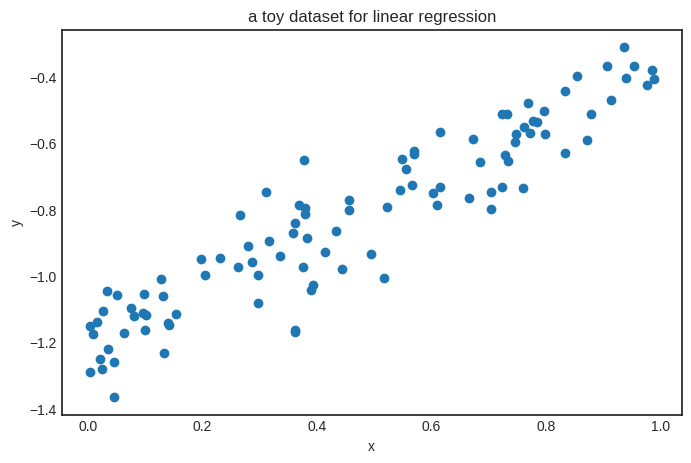

In [26]:
import matplotlib.pyplot as plt


with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 5))
    plt.scatter(xs, ys)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('a toy dataset for linear regression')
    plt.show()

We'll also need a loss function as well. Let's go with the simplest one: the mean squared error, defined by the formula

$$
\mathrm{MSE}(\widehat{\mathbf{y}}, \mathbf{y}) = \frac{1}{N} \sum_{i=1}^{N} (\widehat{y_i} - y_i)^2,
$$

where $ \widehat{\mathbf{y}} \in \mathbb{R}^N $ is the vector of predictions, while $ \mathbf{y} \in \mathbb{R}^N $ is the vector of ground truths.

In [27]:
from mlfz.nn.scalar.loss import mean_squared_error


preds = [linear(x) for x in xs]
mean_squared_error(preds, ys)


Scalar(5.247786926840769)

We have everything ready to train our model with gradient descent.

In [28]:
n_steps = 100
lr = 0.2


for i in range(1, n_steps + 1):
    preds = [linear(x) for x in xs]
    l = mean_squared_error(preds, ys)
    l.backward()
    linear.gradient_update(lr=lr)
    
    if i == 1 or i % 10 == 0:
        print(f"step no. {i}, loss = {l.value}")

step no. 1, loss = 5.247786926840769
step no. 10, loss = 0.03791928155722414
step no. 20, loss = 0.025165368603504518
step no. 30, loss = 0.018080025910402843
step no. 40, loss = 0.014135150067977314
step no. 50, loss = 0.011938778463592476
step no. 60, loss = 0.010715914065005468
step no. 70, loss = 0.010035065098306872
step no. 80, loss = 0.009655991739077368
step no. 90, loss = 0.009444936690592348
step no. 100, loss = 0.009327428476399852


Here's the result.

In [29]:
linear.parameters()

{'a': Scalar(0.7868654698699561), 'b': Scalar(-1.1892905299491128)}

Looks good! The parameters seem close to the target function $ h(x) = 0.8x - 1.2 $. Here's the plot.

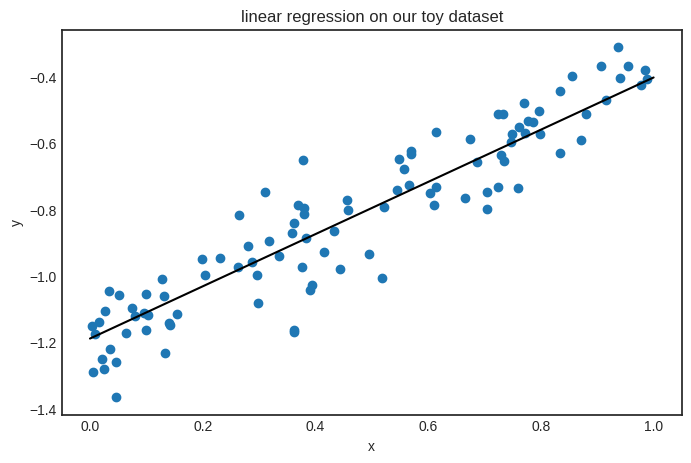

In [30]:
with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 5))

    xs_plot = [0.01 * k for k in range(101)]
    ys_plot = [linear(x).value for x in xs_plot]
    plt.plot(xs_plot, ys_plot, c="k")

    plt.scatter(xs, ys)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('linear regression on our toy dataset')
    plt.show()

## Optimizers

Although training a model using vanilla gradient descent doesn't require more than five lines of code, ready-made optimizers are available. (For now, only gradient descent is implemented, but more will come, including stochastic gradient descent, Adagrad, and others.)

In [31]:
from mlfz.nn.scalar.optimizer import GradientDescent


linear = Linear()
optimizer = GradientDescent(model=linear, loss=mean_squared_error)
optimizer.run(xs, ys, lr=0.1, n_steps=1000)

The result is the same. Check it out:

In [32]:
linear.parameters()

{'a': Scalar(0.8262635419134793), 'b': Scalar(-1.208719738941097)}

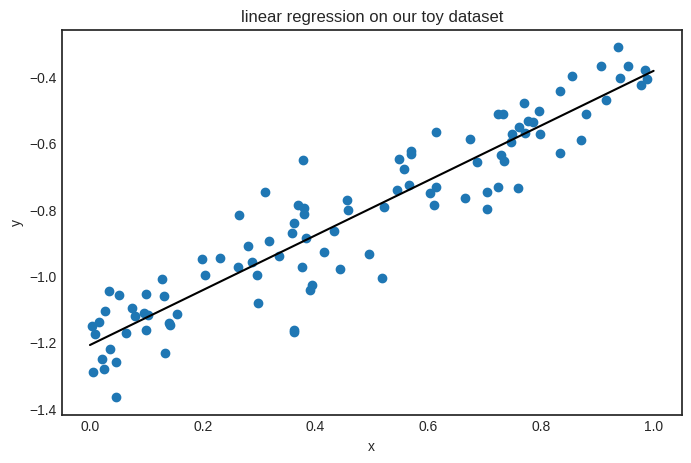

In [33]:
with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 5))

    xs_plot = [0.01 * k for k in range(101)]
    ys_plot = [linear(x).value for x in xs_plot]
    plt.plot(xs_plot, ys_plot, c="k")

    plt.scatter(xs, ys)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('linear regression on our toy dataset')
    plt.show()

## Saving and loading parameters

Let's go back to square one. The `Model` class allows you to save and load parameters dynamically.

In [34]:
linear = Linear()

linear.parameters()

{'a': Scalar(1), 'b': Scalar(1)}

In [35]:
linear.load_parameters({"a": Scalar(-1), "b": Scalar(-1)})
linear.parameters()

{'a': Scalar(-1), 'b': Scalar(-1)}

If you need the parameters in a vanilla Python version, just use the `Model.parameter_values` method.

In [36]:
linear.parameter_values()

{'a': -1, 'b': -1}

Keep in mind that in Python, `Scalar` objects are stored by reference, unlike, say, a Python `float`. This means that if you save the parameter dictionary and then use gradient descent to tune the parameters, your saved parameter dictionary will also change. Take a look.

In [37]:
print("using Model.parameters():")
linear = Linear()
p = linear.parameters()
print(f"before: p = {p}")

preds = [linear(x) for x in xs]
l = mean_squared_error(preds, ys)
l.backward()
linear.gradient_update(lr=10)
print(f"after: p = {p}")

using Model.parameters():
before: p = {'a': Scalar(1), 'b': Scalar(1)}
after: p = {'a': Scalar(-20.247864999327636), 'b': Scalar(-44.76434531118993)}


To avoid issues from this, we can use the `Model.copy_parameters` method.

In [38]:
print("using Model.copy_parameters():")
linear = Linear()
p = linear.copy_parameters()
print(f"before: p = {p}")

preds = [linear(x) for x in xs]
l = mean_squared_error(preds, ys)
l.backward()
linear.gradient_update(lr=10)
print(f"after: p = {p}")

using Model.copy_parameters():
before: p = {'a': Scalar(1), 'b': Scalar(1)}
after: p = {'a': Scalar(1), 'b': Scalar(1)}


Parameter saving and loading are useful if you want to visualize the model's state during training. Here's an example demonstrating how gradient descent fits a linear regression model.

In [39]:
linear = Linear()

n_steps = 200
lr = 0.01

parameter_list = [linear.copy_parameters()]

for _ in range(n_steps):
    preds = [linear(x) for x in xs]
    l = mean_squared_error(preds, ys)
    l.backward()
    linear.gradient_update(lr)
    parameter_list.append(linear.copy_parameters())

/tmp/ipykernel_16322/2321412048.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 0.0), loc='lower left')


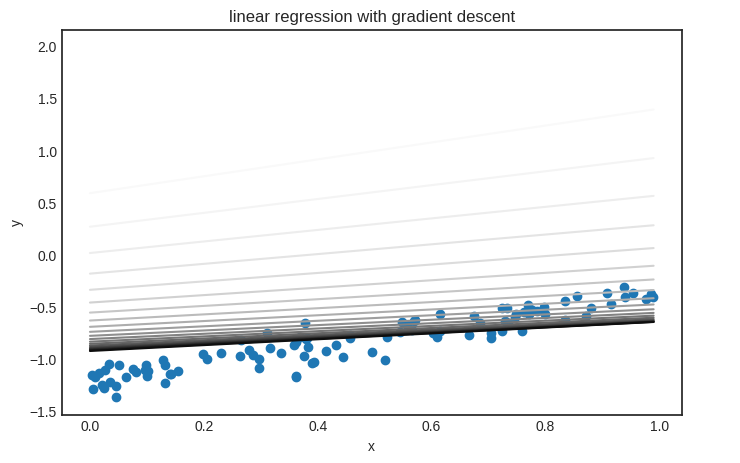

In [40]:
from matplotlib import colormaps

color_map = colormaps['Greys']

with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(8, 5))
    plt.scatter(xs, ys)

    xs_plot = [k*0.01 for k in range(100)]

    trimmed_parameter_list = parameter_list[::10]
    for i, params in enumerate(trimmed_parameter_list):
        color = color_map(i / len(trimmed_parameter_list))
        linear.load_parameters(params)
        ys_plot = [linear(x).value for x in xs_plot]
        plt.plot(xs_plot, ys_plot, color=color)

    plt.title("linear regression with gradient descent")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(bbox_to_anchor=(1.05, 0.0), loc='lower left')
    plt.show()

It's time to see an actual neural network!